In [1]:
import numpy as np

from scipy import ndimage
from scipy import misc
from scipy import linalg
from scipy import argsort
from scipy import signal
from scipy import interpolate
import itertools
import os
import glob

from mpl_toolkits.axes_grid1 import make_axes_locatable

import h5py as h5

from pylab import *

%matplotlib inline
rcParams['figure.figsize'] = 12, 8  # that's default image size for this interactive session
plt.rcParams['animation.ffmpeg_path'] = '/usr/local/bin/ffmpeg'

import mayavi.mlab as mlab
%load_ext imayavi

In [2]:
import matplotlib.animation as animation

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import fibers

In [5]:
from progress import ProgressBar

# Load Danio data

In [6]:
infile = 'Drerio4.h5'

In [7]:
f = h5.File(infile,'a')
imgdata = f['image']
print imgdata.shape

(690, 1235, 2237)


In [8]:
gridsize = 64
gridoverlap = 0.5

gridi = np.arange(gridsize,imgdata.shape[0]-gridsize,int(np.floor(gridsize*(1-gridoverlap))))
gridj = np.arange(gridsize,imgdata.shape[1]-gridsize,int(np.floor(gridsize*(1-gridoverlap))))
gridk = np.arange(gridsize,imgdata.shape[2]-gridsize,int(np.floor(gridsize*(1-gridoverlap))))

In [9]:
grid = np.zeros((3,len(gridi),len(gridj),len(gridk)),dtype=np.int)

#broadcast the grid locations across the new matrix
grid[0,:,:,:] = gridi[:,np.newaxis,np.newaxis]
grid[1,:,:,:] = gridj[np.newaxis,:,np.newaxis]
grid[2,:,:,:] = gridk[np.newaxis,np.newaxis,:]

## Load one volume and test

In [10]:
print (len(gridi), len(gridj), len(gridk))

(40, 74, 136)


In [11]:
ex = (17,25,61)
print grid[(slice(None),)+ex]

[ 304  432 1008]


In [12]:
gridsz2 = (gridsize+1)//2
rng = [slice(grid11-gridsz2,grid11+gridsz2) for grid11 in grid[(slice(None),)+ex]]
I1 = imgdata[rng[0],rng[1],rng[2]]

In [13]:
i = np.arange(I1.shape[0]) - I1.shape[0]/2
[i,j,k] = meshgrid(i,i,i, indexing='ij')

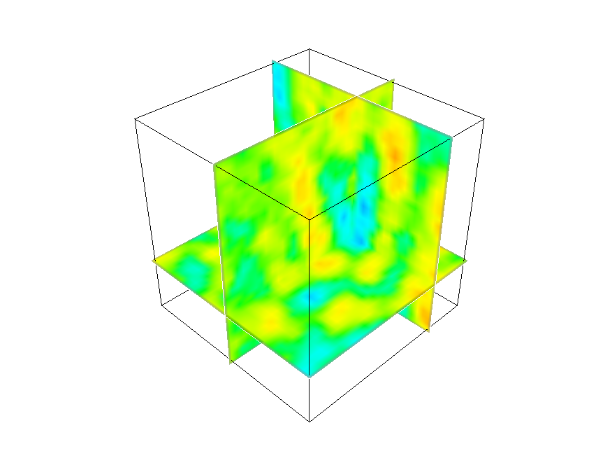

In [14]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(i,j,k, I1, colormap='cool')

mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                slice_index=int(i.shape[0]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                slice_index=int(i.shape[1]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                slice_index=int(i.shape[2]/2))
mlab.outline()

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

In [15]:
vr,w,C = fibers.fiber_angle(I1, returncorr=True)

a = np.arange(C.shape[0]) - C.shape[0]/2
[a,b,c] = meshgrid(a,a,a, indexing='ij')

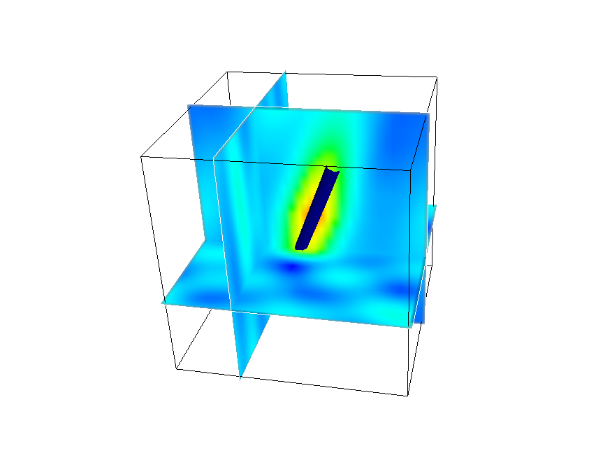

In [16]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(a,b,c, C)

mlab.pipeline.image_plane_widget(sf, plane_orientation='x_axes',
                                slice_index=int(a.shape[0]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='y_axes',
                                slice_index=int(a.shape[1]/2))
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                slice_index=int(a.shape[2]/2))
mlab.outline()

vec = np.vstack((-vr[:,0],vr[:,0]))
mlab.plot3d(vec[:,0]*8,vec[:,1]*8,vec[:,2]*8, color=(0,0,0.7),
           tube_radius=1.0)

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

In [10]:
outfilename = 'Drerio4-data64x64x64.h5'

In [11]:
outfile = h5.File(outfilename,'a')

# Get the volume statistics

In [12]:
means = np.zeros(grid.shape[1:])

In [14]:
gridsz2 = (gridsize+1)//2

In [15]:
with ProgressBar(total=np.prod(grid.shape[1:])) as p:
    for i,j,k in itertools.product(xrange(grid.shape[1]),
                                   xrange(grid.shape[2]),
                                   xrange(grid.shape[3])):
        rng = [slice(grid1-gridsz2,grid1+gridsz2) for grid1 in grid[:,i,j,k]]
        I1 = imgdata[rng[0],rng[1],rng[2]].astype(float)/65536

        means[i,j,k] = np.mean(I1)
        p.update(1)

[------------------------------------------------------------>] 100%  1m 1sec elapsed, 0sec remaining


Save the data

In [16]:
outfile.create_dataset('means',data=means,chunks=True)

<HDF5 dataset "means": shape (18, 35, 66), type "<f8">

In [17]:
outfile.create_dataset('grid',data=grid,chunks=True)

<HDF5 dataset "grid": shape (3, 18, 35, 66), type "<i8">

In [18]:
imgdatamean = np.mean(means)
imgdatastd = np.std(means)

print "Mean: {}, Stdev: {}".format(imgdatamean, imgdatastd)

Mean: 0.159504185248, Stdev: 0.124516136953


# Run through the whole volume

In [19]:
def process_volume(grid, gridsize, insz, good=None, progress=None):
    eigvals = np.zeros((3,)+grid.shape[1:])
    eigvecs = np.zeros((3,3)+grid.shape[1:])
    gridsz2 = (gridsize+1)//2

    #equivalent of a three way nested loop
    for i,j,k in itertools.product(xrange(grid.shape[1]),
                                   xrange(grid.shape[2]),
                                   xrange(grid.shape[3])):
        
        if (good is None) or good[i,j,k]:
            rng = [slice(grid1-gridsz2,grid1+gridsz2) for grid1 in grid[:,i,j,k]]
            I1 = imgdata[rng[0],rng[1],rng[2]].astype(float)/65536

            vr1,w1 = fibers.fiber_angle(I1, normalize=True)

            eigvals[:,i,j,k] = real(w1)
            eigvecs[:,:,i,j,k] = vr1                

        if progress is not None:
            progress.update(1)
    
    return eigvecs, eigvals

In [20]:
good = means > 0.5*imgdatamean

In [21]:
with ProgressBar(total=np.prod(grid.shape[1:])) as p:
    ev,w = process_volume(grid, gridsize, insz=None, good=good, progress=p)

[------------------------------------------------------------>] 100%  12m 42sec elapsed, 0sec remaining


In [22]:
outfile.create_dataset('eigvals',data=w,chunks=True)
outfile.create_dataset('eigvecs',data=ev,chunks=True)

<HDF5 dataset "eigvecs": shape (3, 3, 18, 35, 66), type "<f8">

In [23]:
outfile.close()

# Load the data from the saved file

In [7]:
outfilename = 'Drerio4-data.h5'

In [8]:
outfile = h5.File(outfilename,'r')

In [9]:
grid = np.array(outfile['grid'])

In [10]:
means = np.array(outfile['means'])
eigvals = np.array(outfile['eigvals'])
eigvecs = np.array(outfile['eigvecs'])

Flip eigenvectors with negative z

In [11]:
for i,j,k,m in itertools.product(xrange(grid.shape[1]),
                                 xrange(grid.shape[2]),
                                 xrange(grid.shape[3]),
                                 xrange(3)):
    if eigvecs[2,m,i,j,k] < 0:
        eigvecs[:,m,i,j,k] = -eigvecs[:,m,i,j,k]

In [12]:
print grid.shape
print eigvecs.shape

(3, 40, 74, 136)
(3, 3, 40, 74, 136)


## Plot a 2D slice

In [13]:
f = h5.File(infile,'a')
imgdata = f['image']
print imgdata.shape

(690, 1235, 2237)


In [14]:
grid[:,17,0,0]

array([304,  32,  32])

In [15]:
imgslice = imgdata[grid[0,17,0,0],:,:]

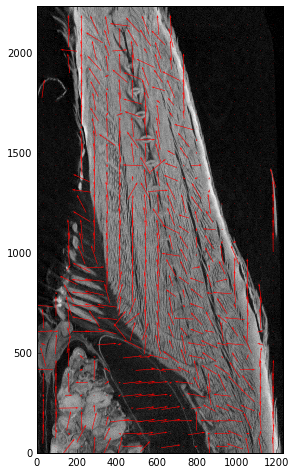

In [16]:
I = np.array(imgdata[300,:,:])
imshow(I.T, cmap=cm.gray, origin='lower')

#plot(grid[1,17,:,:],grid[2,17,:,:],'r.')
skip = 4
quiver(grid[1,17,::skip,::skip],grid[2,17,::skip,::skip],
       eigvecs[1,0,17,::skip,::skip],eigvecs[2,0,17,::skip,::skip], 
       color='r',
       pivot='mid',
      angles='xy',scale=0.05,scale_units='dots')

show()

In [17]:
grid[:,0,0,70]

array([  32,   32, 1152])

In [18]:
imgslice = imgdata[:,:,grid[2,0,0,70]]

In [19]:
eigvalmag = np.linalg.norm(eigvals,axis=0)
eigvalmag[eigvalmag == 0] = 1

In [20]:
eigvalscale = eigvals / eigvalmag[np.newaxis,:,:,:]
eigvalscale[eigvalscale == 0] = np.nan

In [32]:
fig,ax = subplots()

skip = 1
k = 10

ax.imshow(imgdata[:,:,grid[2,0,0,k]].T, cmap=cm.gray, origin='lower')

angyz = np.arctan2(eigvecs[1,0,::skip,::skip,k], eigvecs[2,0,::skip,::skip,k])
im = ax.quiver(grid[0,::skip,::skip,k],grid[1,::skip,::skip,k],
          eigvecs[0,0,::skip,::skip,k],eigvecs[1,0,::skip,::skip,k], 
          angyz*180/np.pi,
          pivot='mid',
          angles='xy',units='dots',scale_units='dots', scale=0.05, width=1.5,
              cmap=cm.hsv)
im.set_clim((-90,90))
cbar = colorbar(im, ax=ax)
cbar.set_label('Saggital plane ange (deg)')
#ax.set_xlim((150,550))
#ax.set_ylim((200,950))
show()

In [42]:
%matplotlib qt

fig, ax = subplots()
im = ax.imshow(imgdata[:,:,grid[2,0,0,20]].T, cmap=cm.gray, origin='lower')
sec = 20
quiv = ax.quiver(grid[0,::skip,::skip,sec],grid[1,::skip,::skip,sec],
          eigvecs[0,0,::skip,::skip,sec],eigvecs[1,0,::skip,::skip,sec], 
          np.arctan2(eigvecs[1,0,::skip,::skip,sec], eigvecs[2,0,::skip,::skip,sec]) * 180/np.pi,
          pivot='mid',
          angles='xy',units='dots',scale_units='dots', scale=0.02, width=2,
                cmap=cm.hsv)
quiv.set_clim((-90,90))
cbar = colorbar(quiv, ax=ax)
cbar.set_label('Saggital plane ange (deg)')

FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=5, metadata=metadata, bitrate=3000)

with writer.saving(fig, "writer_test.mp4", 250):
    for sec in np.arange(1,100):
        im.set_array(imgdata[:,:,grid[2,0,0,sec]].T)
        quiv.set_UVC(eigvecs[0,0,::skip,::skip,sec],eigvecs[1,0,::skip,::skip,sec], 
              np.arctan2(eigvecs[1,0,::skip,::skip,sec], eigvecs[2,0,::skip,::skip,sec])*180/np.pi)
        writer.grab_frame()

#Writer = animation.writers['ffmpeg']
#writer = Writer(fps=5, bitrate=1800)

#anim = animation.FuncAnimation(fig, animate_xsec, frames=np.arange(20,100), fargs=(quiv,), interval=50, blit=False)
#show()

#anim.save('crosssec.mp4', writer="ffmpeg", fps=5, )

In [51]:
%matplotlib qt

skip = 2
fig, ax = subplots()
im = ax.imshow(imgdata[grid[0,10,0,0],:,:].T, cmap=cm.gray, origin='lower')
sec = 20
quiv = ax.quiver(grid[1,sec,::skip,::skip],grid[2,sec,::skip,::skip],
          eigvecs[1,0,sec,::skip,::skip],eigvecs[2,0,sec,::skip,::skip], 
          np.arctan2(eigvecs[1,0,sec,::skip,::skip], eigvecs[2,0,sec,::skip,::skip]) * 180/np.pi,
          pivot='mid',
          angles='xy',units='dots',scale_units='dots', scale=0.05, width=3,
                cmap=cm.hsv)
quiv.set_clim((-90,90))
cbar = colorbar(quiv, ax=ax)
cbar.set_label('Saggital plane ange (deg)')

FFMpegWriter = animation.writers['ffmpeg']
metadata = dict(title='Movie Test', artist='Matplotlib',
                comment='Movie support!')
writer = FFMpegWriter(fps=2.5, metadata=metadata, bitrate=3000)

with writer.saving(fig, "saggital.mp4", 250):
    for sec in np.arange(grid.shape[1]):
        im.set_array(imgdata[grid[0,sec,0,0],:,:].T)
        quiv.set_UVC(eigvecs[1,0,sec,::skip,::skip],eigvecs[2,0,sec,::skip,::skip], 
              np.arctan2(eigvecs[1,0,sec,::skip,::skip], eigvecs[2,0,sec,::skip,::skip])*180/np.pi)
        writer.grab_frame()

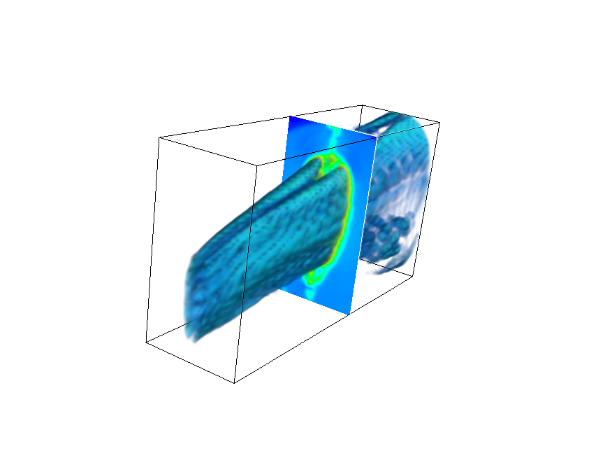

In [38]:
%matplotlib inline

mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(grid[0,:,:,:],grid[1,:,:,:],grid[2,:,:,:], means)

mlab.pipeline.volume(sf, vmin=0.3, vmax=1)
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                slice_index=int(grid.shape[3]/2))
mlab.outline()

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

<IPython.core.display.Javascript object>


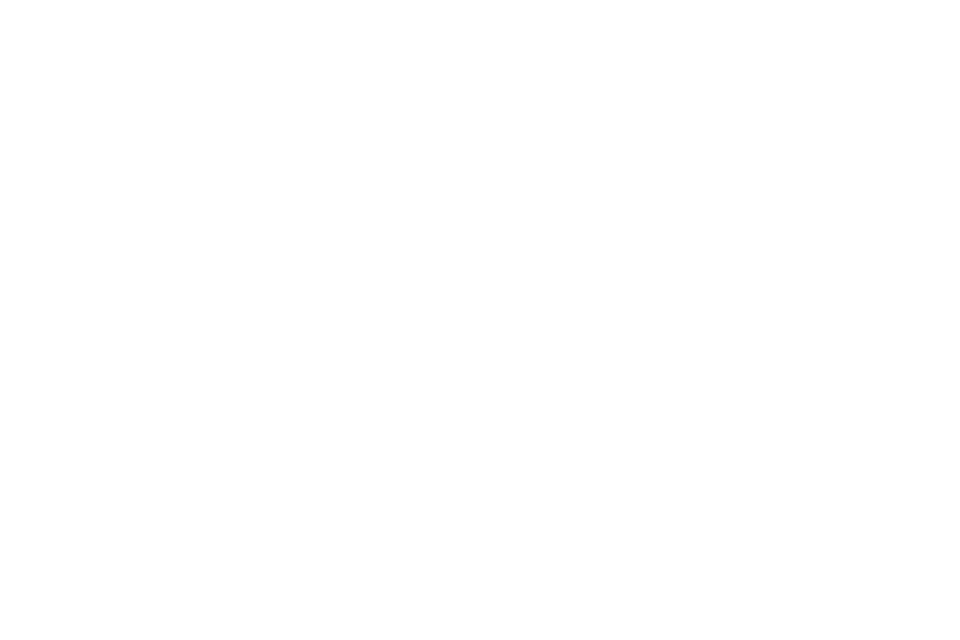

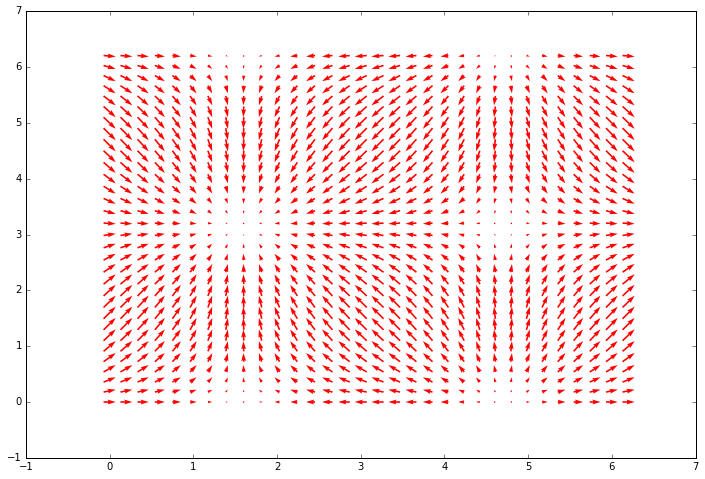

In [47]:
%matplotlib qt

X, Y = np.mgrid[:2*np.pi:0.2,:2*np.pi:0.2]
U = np.cos(X)
V = np.sin(Y)

fig, ax = subplots(1,1)
Q = ax.quiver(X, Y, U, V, pivot='mid', color='r', units='inches')

ax.set_xlim(-1, 7)
ax.set_ylim(-1, 7)

def update_quiver(num, Q, X, Y):
    """updates the horizontal and vertical vector components by a
    fixed increment on each frame
    """

    U = np.cos(X + num*0.1)
    V = np.sin(Y + num*0.1)

    Q.set_UVC(U,V)

    return Q,

# you need to set blit=False, or the first set of arrows never gets
# cleared on subsequent frames
anim = animation.FuncAnimation(fig, update_quiver, fargs=(Q, X, Y),
                               interval=10, blit=False)

show()

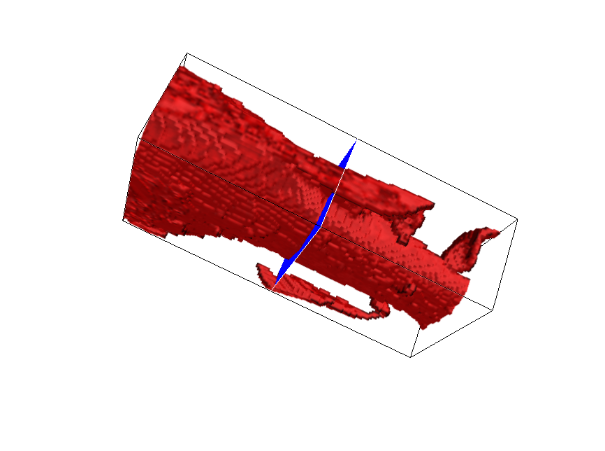

In [40]:
mlab.figure(bgcolor=(1,1,1), fgcolor=(0,0,0))
sf = mlab.pipeline.scalar_field(grid[0,:,:,:],grid[1,:,:,:],grid[2,:,:,:], -eigvals[0,:,:,:])

mlab.pipeline.volume(sf, vmin=0, vmax=0.5)
mlab.pipeline.image_plane_widget(sf, plane_orientation='z_axes',
                                slice_index=int(grid.shape[3]/2))
mlab.outline()

mlab.show(stop=True)

mayavi_show_inline(size=(800,600))

/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in divide
/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in divide
/Users/etytel01/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in divide


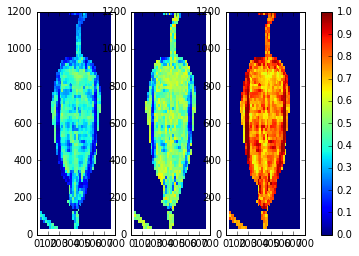

In [52]:
k = 70

eigmag = np.linalg.norm(eigvals,axis=0)

fig,ax = subplots(1,3)
im = ax[0].pcolormesh(grid[0,:,:,k],grid[1,:,:,k],-eigvals[0,:,:,k]/eigmag[:,:,k])
im.set_clim(0,1)

im = ax[1].pcolormesh(grid[0,:,:,k],grid[1,:,:,k],-eigvals[1,:,:,k]/eigmag[:,:,k])
im.set_clim(0,1)

im = ax[2].pcolormesh(grid[0,:,:,k],grid[1,:,:,k],-eigvals[2,:,:,k]/eigmag[:,:,k])
im.set_clim(0,1)
colorbar(im,ax=ax.tolist())

show()